In [1]:
%%capture
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import HTML
from jupyter_plotly_dash import JupyterDash
from dash.dependencies import Input, Output, State
import dash_core_components as dcc
import dash_html_components as html
import plotly.graph_objects as go
import numpy as np
import os
from sys import path as syspath
syspath.append(os.path.expanduser("~/srdjan_functs/"))
from sys import exc_info
from caiman import movie as cmovie
import json

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
%load_ext autoreload
%autoreload 1
%aimport Regions, physio_def_1, numeric, Automatic

from physio_def_1 import *
from Regions import Regions
from numeric import *
from Automatic import *

In [4]:
os.chdir(os.path.expanduser("~"))

In [5]:
# exampleNpzFile = "local_data/testdir/Experiment38a_7_Series016.npz"
exampleNpzFile = "local_data/Sandra/2019_10_15/Experiment38a/Experiment38a_10_Series019.npz"
# exampleNpzFile = "local_data/MB/Marjan_SOC2/20160218/Experiment_10_Series022.npz"
# exampleNpzFile = "local_data/Sandra/2019_10_16/Experiment39a/Experiment39a_13_Series024.npz"
# exampleNpzFile = "local_data/Sandra/2019_10_16/Experiment39a/Experiment39a_8_Series019.npz"

In [6]:
# @app.callback(
#     [Output("show_selected_traces", "figure"),
#      Output("spare_out", "children"),
#     ],
#     [Input("selected_indices", "value")],
#     [State("show_freq_input", "value"),
#      State("show_filtered_choice", "value"),
#      State("offset_input", "value"),],)
# def plotTraces_callback(chosen, showFreq, showFiltered, offset, forceOffset=False):

In [7]:
def saveRois(regions,outDir,filename="",movie=None,cols=["trace"],):
    feedback = []
    try:
        from copy import deepcopy
        from datetime import date
        import pickle
        import pandas as pd
        from os.path import isdir
        from os import makedirs
        regions.sortFromCenter()
        if movie is not None:
            regions.update(movie)
        filename = filename.replace(" ","_")
        today = date.today()
        if len(filename):
            filename = "_".join([today.strftime("%Y_%m_%d"),filename])
        else:
            filename = today.strftime("%Y_%m_%d")
        if not isdir(outDir):
            makedirs(outDir)
            feedback += f"Output {outdir} directory created."

        traces = pd.DataFrame(np.vstack(regions.df.trace).T)
        traces["time"] = traces.index/regions.movie.fr
        traces = traces[["time"]+list(traces.columns[:-1])]
        tracefile = f"{outDir}/{filename}_trace.csv"
        traces.to_csv(tracefile, index=False)

        feedback += [f"Traces saved under {tracefile}.",html.Br()]

        saving = ['statImages', 'mode', 'image', 'filterSize', 'df']
        allAttrs = list(regions.__dict__.keys())
        subRegions = deepcopy(regions)
        for k in allAttrs:
            if k not in saving:
                del subRegions.__dict__[k]
        for k in regions.df.columns:
            if k not in ["peak", "pixels"]:
                del subRegions.df[k]
        roifile = f"{outDir}/{filename}_rois.pkl"
        with open(roifile,"wb") as f:
            pickle.dump(subRegions,f)
        feedback += [f"ROI info saved under {roifile}."]
    except:
        from sys import exc_info
        feedback += ["ERROR: "+ exc_info().__repr__()]
    return feedback

In [8]:
outputStyle = {
    "color":"blue",
    "font-family":"Courier New",
    "font-size":"80%",
    "max-width": "700px",
    }
infoStyle = {
    "font-size":"70%",
    "font-family":"Arial",
    # "background-color":"lightcyan",
    "color":"grey",
    "max-width": "700px",
    }
bodyStyle = {
    "font-family":"Arial",
    "max-width": "700px",
    }

In [9]:
baseFig = getFigure(w=200,h=20)

In [10]:
## global vars
test = False#"srdjan" in os.getcwd()
npzFile = None
metadata = None
movie = None
regions = None
narrowHover = False#bool(test)

In [ ]:
debug = False#"srdjan" in os.getcwd()

In [11]:
if test:
    %config InlineBackend.figure_format = 'retina'

In [12]:

app = JupyterDash(__name__,
                  width=1000,
#                   height=1400,
                 )

APP_LAYOUT = [
    
    html.H1(children='CaRec Viewer',style=bodyStyle),
    html.Div("Please, think of a better name and let me know.",style=infoStyle),
    html.Br(),
    ####################################
#     html.H2(children='Importing',style=bodyStyle),
    html.Div('Enter path to an npz file, choose whether to check for movement, and press enter.',style={**bodyStyle, "display":"inline-box"}),
    html.Div([
        dcc.Checklist(id="check_movement_choice",
                      options=[{"label":'Check for movement',"value":"yes"}],
                      value=[],
                      labelStyle={'vertical-align': 'top'},
                      style={**infoStyle, "display":"inline-box","float":"right"}),
    ],style={"width":"200px"}),
    
    dcc.Input(id="npz_filename",
            type="text",
            placeholder=exampleNpzFile,
            debounce=True,
            size = 100,
            value=exampleNpzFile if test else "",
        ),

#     html.Div('Loading can take a few seconds [for very large files even a minute].',style={**infoStyle,"text-align": "center"}),
    html.Br(),
    
    html.Div(id="npz_feedback", children="",style=outputStyle),#To start, enter the full path to a file and press enter. Note, that loading can take a few seconds [for very large files even a minute].

    html.Div(children=[html.Br(),"    Spatial filtering "],style={**bodyStyle,'display': 'inline-block'}),

    dcc.Input(id="gSig_filt_input",
        type="text",
        debounce=True,
        size = 5,
        value="",
        placeholder="3",
        style={'display': 'inline-block'}),    

    html.Div(html.Abbr(
        children="[hover mouse for more info]",
        title="""For the proper analysis, you need to set the size of the spatial filter. Its value should be of the order of the  half of the typical cell dimension (in pixels!). """#In many of our recording, pixel size is around 2 µm. If we consider a typical cell of 10 µm, filter should be around 10/2/2 = 2.5. It needs to be an integer, so reasonable numbers to put would be 2 or 3, perhaps even 4. You can change it later.
        ),style={**infoStyle,'display': 'inline-block'}),

    html.Div(id="roi_feedback", children="",style=outputStyle),
    
    dcc.Graph(id='stat_images',figure=baseFig,),

    html.Div(children="Resample",style={'display': 'inline-block'}),
    
    dcc.Input(id="resample_input",
        type="text",
        debounce=True,
        size = 5,
        placeholder="5",
        value="30",
        style={'display': 'inline-block'}),
    
    html.Div(children=" ",style={"width":"20px",'display': 'inline-block'}),
    html.Div(children=" ", id="resample_feedback",
             style={'display': 'inline-block',**outputStyle}),
    
    html.Div(style=infoStyle,
        children=[
        """
        [Resampling is optional (and irreversible). It is only useful to speed up the analysis downstream.
        Enter the new desired frequency in Hz (e.g. 5), and press enter.
        """,
        html.Br(),],),

    html.Div(children="Filter",style={'display': 'inline-block'}),
    
    dcc.Input(id="filter_input",
        type="text",
        debounce=True,
        size = 5,
        placeholder="2",
        value="",
        style={'display': 'inline-block'}),
    
    html.Div(children=" ",style={"width":"20px",'display': 'inline-block'}),
    html.Div(children=" ", id="filter_feedback",
             style={'display': 'inline-block',**outputStyle}),
    
    html.Div(style=infoStyle,
        children=[
        """
        Use this if you wish to see and/or output traces prefiltered.
        Input the time scale (in seconds) of the longest event you wish to keep (e.g. 2), and press enter.
        """,
        html.Br(),],),
    
    html.H3(children='ROIs', style=bodyStyle),
    
    html.Div([
        "Show downsampled to",
        dcc.Input(id="show_freq_input",
            type="text",
            debounce=False,
            size = 3,
            value='5'),
        "Hz"
        ], style={**bodyStyle,"display":"inline-block", "width":"49%"}, ),
    dcc.Checklist(id="show_filtered_choice",
                  options=[{"label":'Show filtered',"value":"yes"}],
                  value=[],
                  labelStyle={'vertical-align': 'bottom'},
                  style={**bodyStyle,"display":"inline-box",}
                 ),
    html.Br(),
    html.Div(dcc.Graph(id='roi_selector',    figure=baseFig), style={"display":"inline-block"}),
    html.Div(dcc.Graph(id='show_hover_trace',figure=baseFig), style={"display":"inline-block"}),
    html.Br(),
    html.Div(children=
        html.Pre(
        id="hover_out",
        children="hover",
        style={
            "vertical-align":"top",
            "width"    : "200px",
            "height"   : "100px" if debug else "0px",
            'border'   : 'thin lightgrey solid',
            'overflowY': 'scroll',
            "display"  : "inline-box"
              }),
             style={"display":"inline-block"}),
    html.Div(children=
        html.Pre(
        id="selected_out",
        children="selected",
        style={
            "vertical-align":"top",
            "width"    : "200px",
            "height"   : "100px" if debug else "0px",
            'border'   : 'thin lightgrey solid',
            'overflowY': 'scroll',
            "display"  : "inline-box"
              }),
             style={"display":"inline-block"}),
    html.Div(children=
        html.Pre(
        id="hover_plot_out",
        children="hover plot out",
        style={
            "vertical-align":"top",
            "width"    : "200px",
            "height"   : "100px" if debug else "0px",
            'border'   : 'thin lightgrey solid',
            'overflowY': 'scroll',
            "display"  : "inline-box"
              }),
             style={"display":"inline-block"}),
    html.Div(children=
        html.Pre(
        id="spare_out",
        children="spare",
        style={
            "vertical-align":"top",
            "width"    : "200px",
            "height"   : "100px" if debug else "0px",
            'border'   : 'thin lightgrey solid',
            'overflowY': 'scroll',
            "display"  : "inline-box"
              }),
             style={"display":"inline-block"}),
    
    html.Div([
       "Trace ROIs:",
        dcc.Input(id="selected_indices",
            type="text",
            debounce=True,
            size=60,
            value="",
         ), 
    ],style={**bodyStyle,"display":"inline-box"}),
    
    html.Div([
        html.Div("Show with offsets", style={**bodyStyle,"display":"inline-block"}),
        html.Div(dcc.Input(id="offset_input",
            type="text",
            debounce=False,
            size=3,
            value='1'), style={**bodyStyle,"display":"inline-block"}),
        html.Div("(only when showing filtered)", style={**infoStyle,"display":"inline-block"}),
    ]),
    html.Br(),
    
    html.Div(dcc.Graph(id='show_selected_traces',figure=getFigure(w=700))),
    

    # html.Div([
    #     "Save tag to selected rois: ",
    #     dcc.Input(id="tag_save",
    #         type="text",
    #         debounce=False,
    #         size = 30,
    #         placeholder="e.g. beta, alpha, edge, central...",
    #         value=''),
    #     html.Div("save_tag_feedback",style=outputStyle,id="save_tag_feedback"),
    # ]),
    
    
    html.H3("Save all"),
    html.Div([
        "When you are happy with your analysis, you can save it. By default, the analysis is saved as the current date (e.g. 2020_02_18) in the directory",
        html.Div("",style=outputStyle,id="analysis_folder"),
        "You can modify the filename by adding to it some other identifier(s) by entering them in the input box below. I suggest your username.",
        "When you are ready, press save."
    ]),
    dcc.Input(id="save_file_append",
        type="text",
        debounce=False,
        size = 30,
        placeholder="e.g. username",
        value='',style={"display":"inline-box"}),
    html.Button('Save', id='save_button', style={"display":"inline-box"},
                n_clicks=0
               ),
    html.Div(id="save_feedback",
             style={"display":"inline-box",**outputStyle}
            )
    ]

test=False

In [13]:
def parseCol(regions, showFreq, filtered):
    if not hasattr(regions,"time"):
        regions.calcTraces(movie)
    if "trace" not in regions.df:
        regions.calcTraces(movie)
    if filtered:
        col = "showFilteredTrace_%.1f"%showFreq
        col0 = "filteredTrace"
    else:
        col = "showTrace_%.1f"%showFreq
        col0 = "trace"
    regions.df[col0]
    if not hasattr(regions,"showTime"):
        print ('creating empty showTime.')
        regions.showTime = {}
    if col not in regions.df.columns:
        n_Avg = int(regions.movie.fr/showFreq)
        n_Avg = max(1,n_Avg)
        if n_Avg<=1:
            regions.showTime[col] = regions.time
            regions.df[col] = regions.df[col0]
        else:
            print ('creating',col)
            regions.showTime[col] = rebin(regions.time,n_Avg)
            regions.df[col] = list(np.ones((len(regions.df),len(regions.showTime[col]))))
            #if filtered:
                #regions.df[col+"_slow"] = list(np.ones((len(regions.df),len(regions.showTime[col]))))
            for i in regions.df.index:
                if i==0:
                    print ("filling in", col)
                regions.df[col].loc[i] = rebin(regions.df.loc[i,col0],n_Avg)
                #regions.df[col+"_slow"].loc[i] = rebin(regions.df.loc[i,col0+"_slow"],n_Avg)
    return col

In [14]:
try: del regions.showTime
except: pass
try:
    for k in regions.df.columns:
        if "show" in k:
            print (k)
            try: del regions.df[k]
            except: pass
except:
    pass

In [15]:
# def runningMode1(x_, filterSize, nbins, boundary="reflective", show=20):
#     if filterSize%2==0:
#         raise ValueError("filter size needs to be odd number")
#     delta = filterSize//2
#     out = np.zeros_like(x_)
#     allowedBoundaries = ["reflective","equal"]
#     if boundary not in allowedBoundaries:
#         raise ValueError(f"boundary {boundary} not recognized. Allowed values are: "+repr(allowedBoundaries))
#     if boundary=="reflective":
#         x_ = np.concatenate((x_[:delta][::-1], x_, x_[-delta:][::-1]))
#     if boundary=="equal":
#         x_ = np.concatenate(([x_[0]]*delta, x_, [x_[-1]]*delta))
#     nshow = len(out)//show
#     for i in range(len(out)):
#         if i%nshow==0:
#             c,v = plt.hist(x_[i:i+filterSize], nbins, histtype="step", label=i)[:2]
#         else:
#             c,v = np.histogram(x_[i:i+filterSize], nbins)
#         ichoose = np.argmax(c)
#         out[i] = v[ichoose]
#     return out

In [16]:
@app.callback(
    [Output("show_selected_traces", "figure"),
     Output("spare_out", "children"),
    ],
    [Input("selected_indices", "value")],
    [State("show_freq_input", "value"),
     State("show_filtered_choice", "value"),
     State("offset_input", "value"),],)
def plotTraces_callback(chosen, showFreq, showFiltered, offset, forceOffset=False):
    try:
        if chosen=="": return baseFig,"waiting"
        global regions,movie
        showFreq = float(showFreq)
        filtered = bool(len(showFiltered))
        if forceOffset:
            offset = float(offset)
        else:
            offset = float(offset) if filtered else 0
        colToshow = parseCol(regions, showFreq, filtered)
        if chosen=="":
            return baseFig, "nothing yet"
        try:
            ix = np.array(chosen.strip(" ,").split(","))
            ix = ix.astype(int)
            trfig = plotTraces(regions,indices=ix,time=regions.showTime[colToshow], showCol=[colToshow], offset=offset)
            trfig.update_layout({"width":800,"height":200+50*np.log(4*len(ix))})
            return trfig,"ok: "+repr((chosen, showFreq, showFiltered, offset))
        except:
            return baseFig,"error in chosen parsing"+repr(chosen)
    except:
        return baseFig,"ERROR from plotTraces_callback: "+exc_info().__repr__() 

In [17]:
# f = plotTraces_callback(
#     chosen="148, 0",
#     showFreq = 10,
#     showFiltered=[],
#     offset = 3,
#     forceOffset=True)[0]


In [18]:
# 167, 190, 210, 22, 260, 41

In [19]:
@app.callback(
    [Output("show_hover_trace", "figure"),
     Output("hover_plot_out", "children")],
    [Input("roi_selector", "hoverData")],
    [State("show_freq_input", "value"),
     State("show_filtered_choice", "value"),])
def plotHovered_callback(hoverData, showFreq, showFiltered):
    try:
        global regions
        showFreq = float(showFreq)
        filtered = bool(len(showFiltered))
        colToshow = parseCol(regions, showFreq, filtered)
        showCol = [colToshow]
        #if filtered:
            #try: showCol += [colToshow+"_slow"]
            #except: pass
        try:
            hoverData.dtype
            ix = hoverData
        except:
            ix = [int(hoverData["points"][0]["hovertext"])]

        trfig = plotTraces(regions,indices=ix,time=regions.showTime[colToshow], showCol=showCol)
        if narrowHover:
            trfig.update_layout({"width":220,"height":200})
        return trfig,"ok "
    except:
        return baseFig,"ERROR from plotHovered_callback: "+exc_info().__repr__() 

In [20]:
@app.callback(
    Output("save_feedback",    "children"),
    [Input("save_button",      "n_clicks")],
    [State("save_file_append", "value"   )]
             )
def save_callback(n_clicks,filename):

    try:
        if n_clicks <= 0:
            return "saving can take a few seconds."
        else:
            global regions, movie, npzFile
            outDir = npzFile.replace(".npz","_analysis")
            return saveRois(regions, outDir, filename, movie=movie)
    except:
            return "ERROR: "+exc_info().__repr__()

In [21]:
@app.callback(
    Output("resample_feedback", "children"),
    [Input("resample_input", "value")]
             )
def resample_callback(val):
    try:
        from Automatic import resample
        if val == "":
            feedback = ""
        else:
            global movie
            newFreq = float(val)
            movie = resample(movie,newFreq)
            feedback = f"Resampling finished. New frequency is {movie.fr:.4} Hz."
            regions.update(movie)
        return feedback
    except:
        return "ERROR: "+exc_info().__repr__()
    

In [22]:
# regions.df["filteredTrace"] = regions.df["faster_6"]
# regions.df["filteredTrace_slow"] = regions.df["slower_6"]

In [23]:
@app.callback(
    Output("filter_feedback", "children"),
    [Input("filter_input", "value")]
             )
def filter_callback(val):
    try:
        if val == "":
            feedback = ""
        else:
            global regions
            timeScale = float(val)
            filterSize = int(timeScale*regions.movie.fr)
            if filterSize<10:
                return f"Filer size would need to be {filterSize}. This is too short time scale. I cannot work like this! :-P"
            feedback = "You chose to discard all time structure longer than %g seconds."%timeScale
            if filterSize<20:
                feedback = " This a rather short time scale, can't guarantee for the results."
            if "faster_%g"%timeScale not in regions.df:
                regions.filter_traces(timeScale,percentile = [5,10,50], calcStd=True)
            regions.df["filteredTrace"] = regions.df["faster_%g"%timeScale]
            regions.df["filteredTrace_slow"] = regions.df["faster_%g"%timeScale]
            for col in regions.df.columns:
                if "show" in col:
                    del regions.df[col]
            feedback += " Filtering successful."
        return feedback
    except:
        return "ERROR: "+exc_info().__repr__()
    

In [24]:
@app.callback([Output("npz_feedback", "children"),
               Output("gSig_filt_input", "value"),
               Output("analysis_folder","children")
              ],
              [Input("npz_filename", "value")],
              [State("check_movement_choice","value")])
def loadMovie(val,mv):
    if str(val)=="":
        return ('Loading can take a some time [for very large files even minutes].',"","")
    try:
        from pandas import read_csv
        global npzFile, movie, metadata, cell_halfwidth_in_px, regions
        npzFile = val
        analysisFolder = npzFile.replace(".npz","_analysis")
        movie = import_npz_files([npzFile])
        movie = movie.astype("float")
        if len(movie.shape)==2:        
            movie = movie.reshape((1,-1))
        movie = cmovie(movie)
        timeframes = len(movie)
        feedback = [
            f"{npzFile} loaded successfully.",
            html.Br(),
            f"The recording consists of {timeframes} frame(s)."
        ]
        feedback += [ ]
        try:
            metadata = read_csv(npzFile.replace("npz","txt")).loc[0]
            if not hasattr(metadata,"freq"):
                metadata.freq = 1
            movie.fr = metadata.freq
            timeframes = metadata['T']
            assert timeframes==len(movie)
            freq = metadata.freq
            pxsize = metadata.pxSize
            feedback += [
                f"Info from metadata: frequency {freq:.4} Hz, and pixel size {pxsize:.3} µm.",
            html.Br(),
            ]
        except:
            pxsize = 1
            freq = 1
            feedback += [
                f"WARNING: Missing medatada. Assuming the frequency of {freq:.4} Hz, and pixel size of {pxsize:.3} µm. I strongly suggest you set the spatial filter carefully.",
            html.Br(),
            ]
        cell_halfwidth_in_px = int(np.ceil(6./pxsize))
        feedback += [
            f"Automatic size of the spatial filter based on pizel size: {cell_halfwidth_in_px} [you can change it below]",
            html.Br(),]
        
        # resample temporarily to lower frequency, to initiate ROIs and check for motion correction
        if freq>3:
            
            freqMC = 3
            n_rebin = int(movie.fr/freqMC)

            rebinned_movie = rebin(movie,n_rebin).astype("float32")
            rebinned_movie = cmovie(rebinned_movie)
            rebinned_movie.fr = movie.fr/n_rebin
        else:
            rebinned_movie = movie.astype("float32")
            feedback += [
                "(This is probably a lot higher frequency than you need, consider resampling to lower frequency, e.g. 5 Hz.)",
                html.Br(),
                        ]
        if len(mv):
            rigidShifts = getRigidShifts(rebinned_movie, (cell_halfwidth_in_px,)*2)
            maxshift = np.abs(rigidShifts).max()
            if maxshift>cell_halfwidth_in_px/5:
                feedback += [
                    f"It seems there is also some movement in the recording, at least {maxshift}px. You may want to first correct for that.",
                    html.Br(),
                ]
                
        # initiate ROIs
        regions = createRegions(rebinned_movie, cell_halfwidth_in_px, mode="diff_std")
        del regions.statImages["diff_mean"]
        regions.update(movie)
        
        return (feedback, str(cell_halfwidth_in_px),analysisFolder)
    except:
        return ([html.P("ERROR: "+exc_info().__repr__())],"None","")

In [25]:
@app.callback(
    [Output("roi_feedback", "children"),
     Output("stat_images", "figure"),
     Output("roi_selector", "figure"),
#      Output("roi_choice","value"),
    ],
    [Input("gSig_filt_input", "value")])
def recalcRois(val):
    if val == "":
        return ("",baseFig,baseFig)
    try:
        global movie,regions
        x = eval(val)
        if type(x) == int:
            x = [x]
        if regions.filterSize != x:
            regions = createRegions(movie, x)
            # merge obvious ROIs
            from Regions import getPeak2BoundaryDF, getGraph_of_ROIs_to_Merge, mergeBasedOnGraph
            while True:
                peak2bnd = getPeak2BoundaryDF(regions.df)
                df = peak2bnd.query("dist<1.")[["i","j"]]
                if len(df)==0: break
                gRois = getGraph_of_ROIs_to_Merge(df,regions,plot=False)
                # plotRoi_to_be_connected(gRois,regions)
                dropped = mergeBasedOnGraph(gRois,regions)
                if dropped == 0: break

            regions.purge_lones((cell_halfwidth_in_px*.5)**2)
            regions.sortFromCenter()
            feedback = [f"Size of the spatial filter changed to {x}.",html.Br()]
        else:
            feedback = [""]
        feedback += [f" Number of detected ROIs: {len(regions.df)}"]
        roisImage = showRoisOnly(regions,indices=range(len(regions.df)),im=regions.statImages["diff_std"])
        if narrowHover:
            roisImage.update_layout({"width":220,"height":240})
        return (feedback, plotStatsFig(regions), roisImage)
    except:
        return ("ERROR from recalcRois: "+exc_info().__repr__(),baseFig,baseFig)

In [26]:
@app.callback(
    Output("hover_out", "children"),
    [Input("roi_selector", "hoverData")],
    )
def showHovered(hoverData):
    try:
        return json.dumps(hoverData, indent=2)
    except:
        return "ERROR from hover: "+exc_info().__repr__() 

@app.callback(
    Output("selected_out", "children"),
    [Input("roi_selector", "selectedData")],
    )
def showSelected(selData):
    try:
        return json.dumps(selData, indent=2)
    except:
        return "ERROR from hover: "+exc_info().__repr__() 


In [27]:
@app.callback(
    Output("selected_indices", "value"),
    [Input("roi_selector", "selectedData")]
)
def collectSelected(selData):
    try:
        out = np.unique([pt["hovertext"] for pt in selData["points"]])
        out = sorted(out,key=int)
        return ", ".join(out)
    except:
        return "" 

In [28]:
# app.layout = html.Div(children=APP_LAYOUT)
# app

In [29]:
app.layout = html.Div(children=APP_LAYOUT)
app._repr_html_() 
link2app = "https://ctn.physiologie.meduniwien.ac.at"+app.get_app_root_url()
HTML(f'open the following link in a different tab (do not close this tab!): <a href="{link2app}">{link2app}</a>')

In [72]:
regions.df.columns

Index(['peak', 'pixels', 'peakValue', 'size', 'interest', 'edges', 'boundary',
       'neighbors', 'Nneighbors', 'medianValue', 'nNonZero', 'distToCenter',
       'trace', 'showTrace_5.0', 'slower_2', 'faster_2', 'faster_2_std',
       'filteredTrace', 'filteredTrace_slow', 'showFilteredTrace_5.0'],
      dtype='object')

In [71]:
# for k in regions.df.columns:
#     if "fast" in k:
#         del regions.df[k]
#     if "slow" in k:
#         del regions.df[k]
#     if "show" in k:
#         del regions.df[k]
#     if "filt" in k:
#         del regions.df[k]

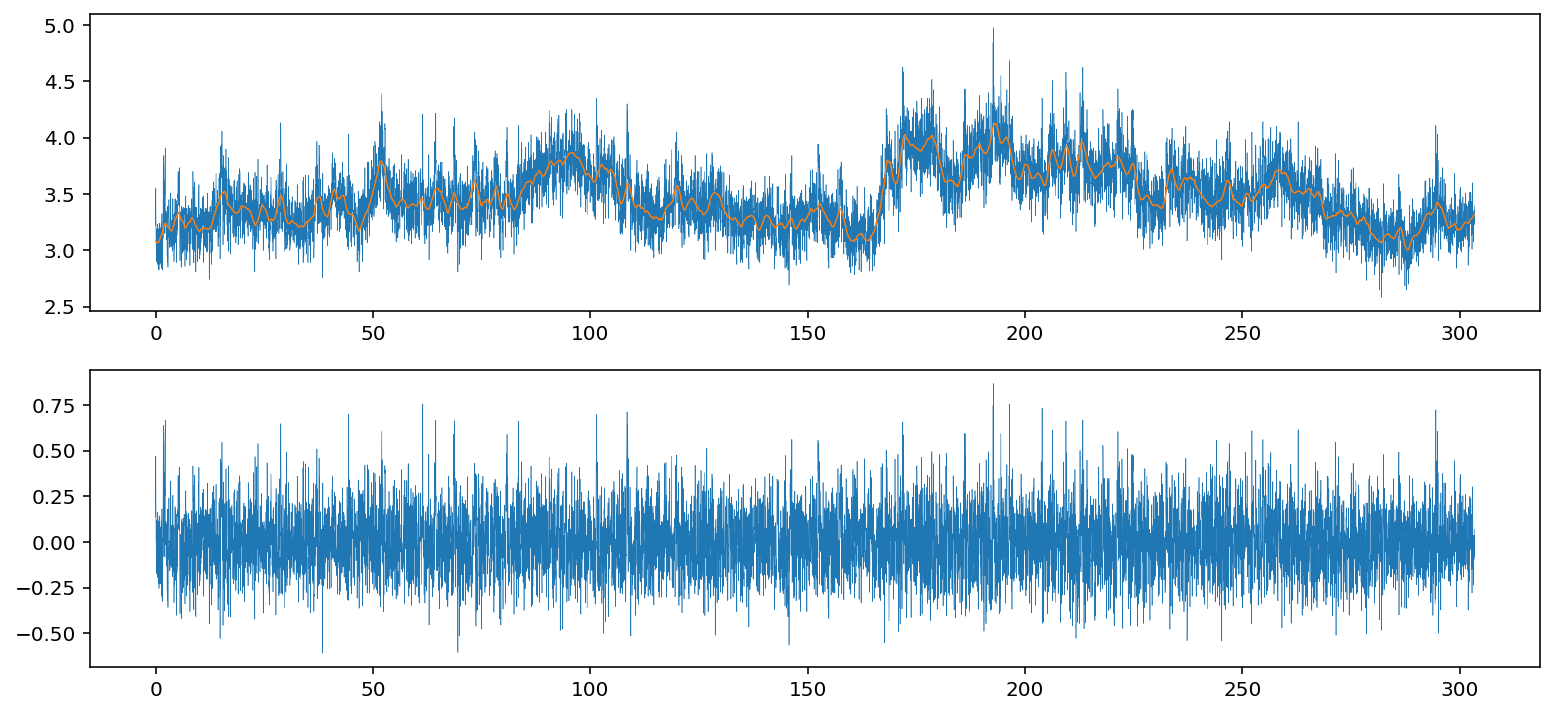

In [31]:
t = regions.time
i = 54
fig, axs = plt.subplots(2,1,figsize=(13,6))
x  = regions.df.loc[i,"trace"].copy()
xs = regions.df.loc[i,"slower_1.5"].copy()
xf = regions.df.loc[i,"faster_1.5"].copy()
axs[0].plot(t, x, lw=.3)
axs[0].plot(t, xs, lw=.7)
axs[1].plot(t, xf, lw=.3)

In [35]:
regions.df.columns

Index(['peak', 'pixels', 'peakValue', 'size', 'interest', 'edges', 'boundary',
       'neighbors', 'Nneighbors', 'medianValue', 'nNonZero', 'distToCenter',
       'trace', 'slower_1.5', 'faster_1.5', 'filteredTrace',
       'filteredTrace_slow', 'showFilteredTrace_5.0', 'showTrace_5.0'],
      dtype='object')

In [32]:
plt.hexbin(regions.df.loc[i,"slower_1.5"][::100], regions.df.loc[i,"faster_1.5_std"][::100])


KeyError: 'faster_1.5_std'

In [66]:
# regions.df.columns

71


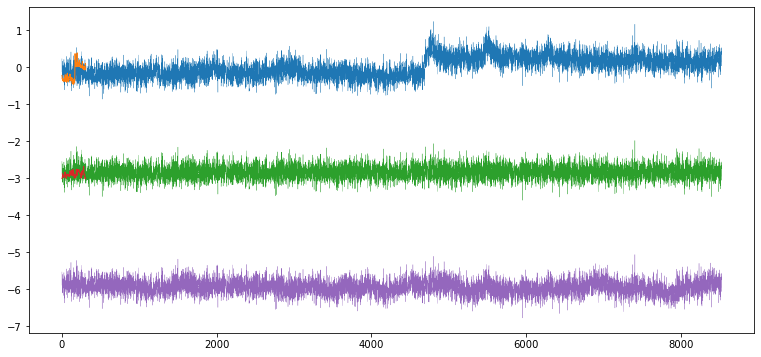

In [45]:

wIron = int(2.5*regions.movie.fr)
if wIron%2==0:
    wIron += 1
print(wIron)
x = x-np.array([np.median(x)]*len(x))
plt.plot(t,x,lw=.3)
ia = 0
n = 3
for f in [
    lambda xi: lowPass(xi,wIron,wIron,[10,20]),
#     lambda xi: lowPass(xi,wIron,wIron,10),
#     lambda xi: lowPass(xi,wIron*2+1,wIron*2+1,10),
    lambda xi: lowPass(runningMode(xi,wIron*2+1,20),wIron*2+1,wIron*2+1,50)
]:
    xf = f(x)
    plt.plot(t,xf+ia*n,lw=1)
    x -= xf
    ia -= 1
    plt.plot(t,x+ia*n,lw=.3)
# plt.xlim(2000,3000)

In [69]:
plotTraces(regions,indices=[79],time=regions.time, showCol=["trace",'slower_2.5','slower_1.5'])

43


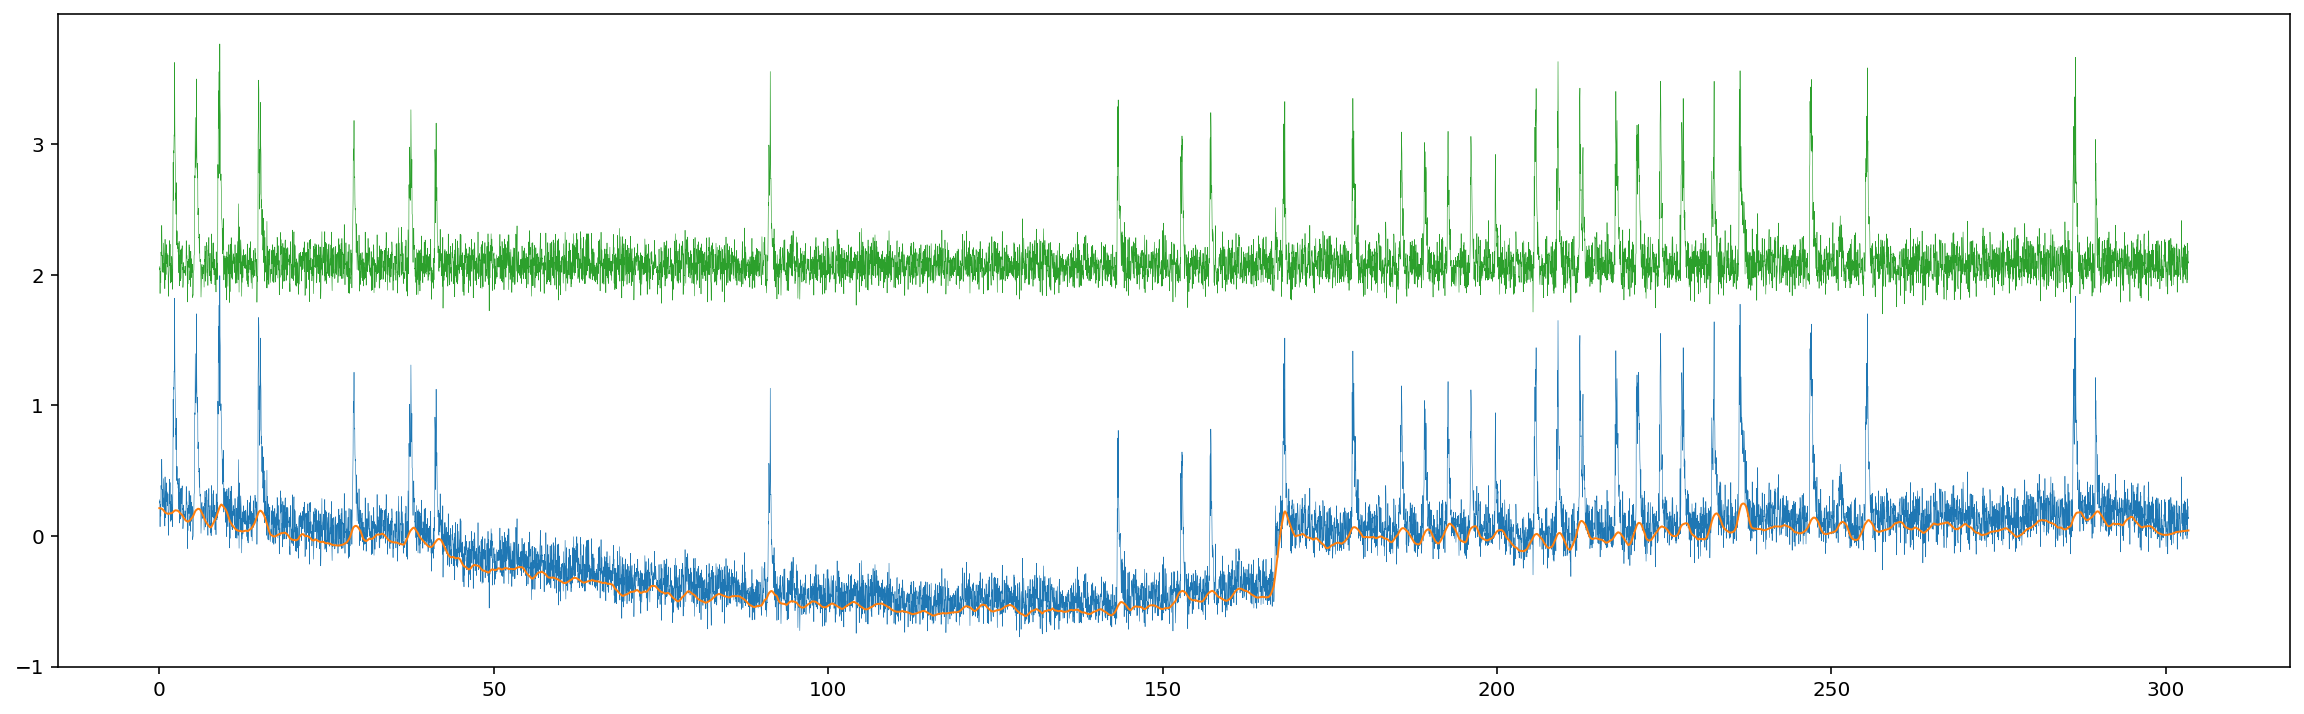

In [70]:
t = regions.time
plt.figure(figsize=(20,6))
x = regions.df.loc[79,"trace"].copy()
wIron = int(1.5*regions.movie.fr)
if wIron%2==0:
    wIron += 1
print(wIron)
x = x-np.array([np.median(x)]*len(x))
plt.plot(t,x,lw=.3)
ia = 0
n = 2

xf = lowPass(x,wIron,wIron,[10,20])
plt.plot(t,xf+ia*n,lw=1)
x -= xf
ia += 1
plt.plot(t,x+ia*n,lw=.3)


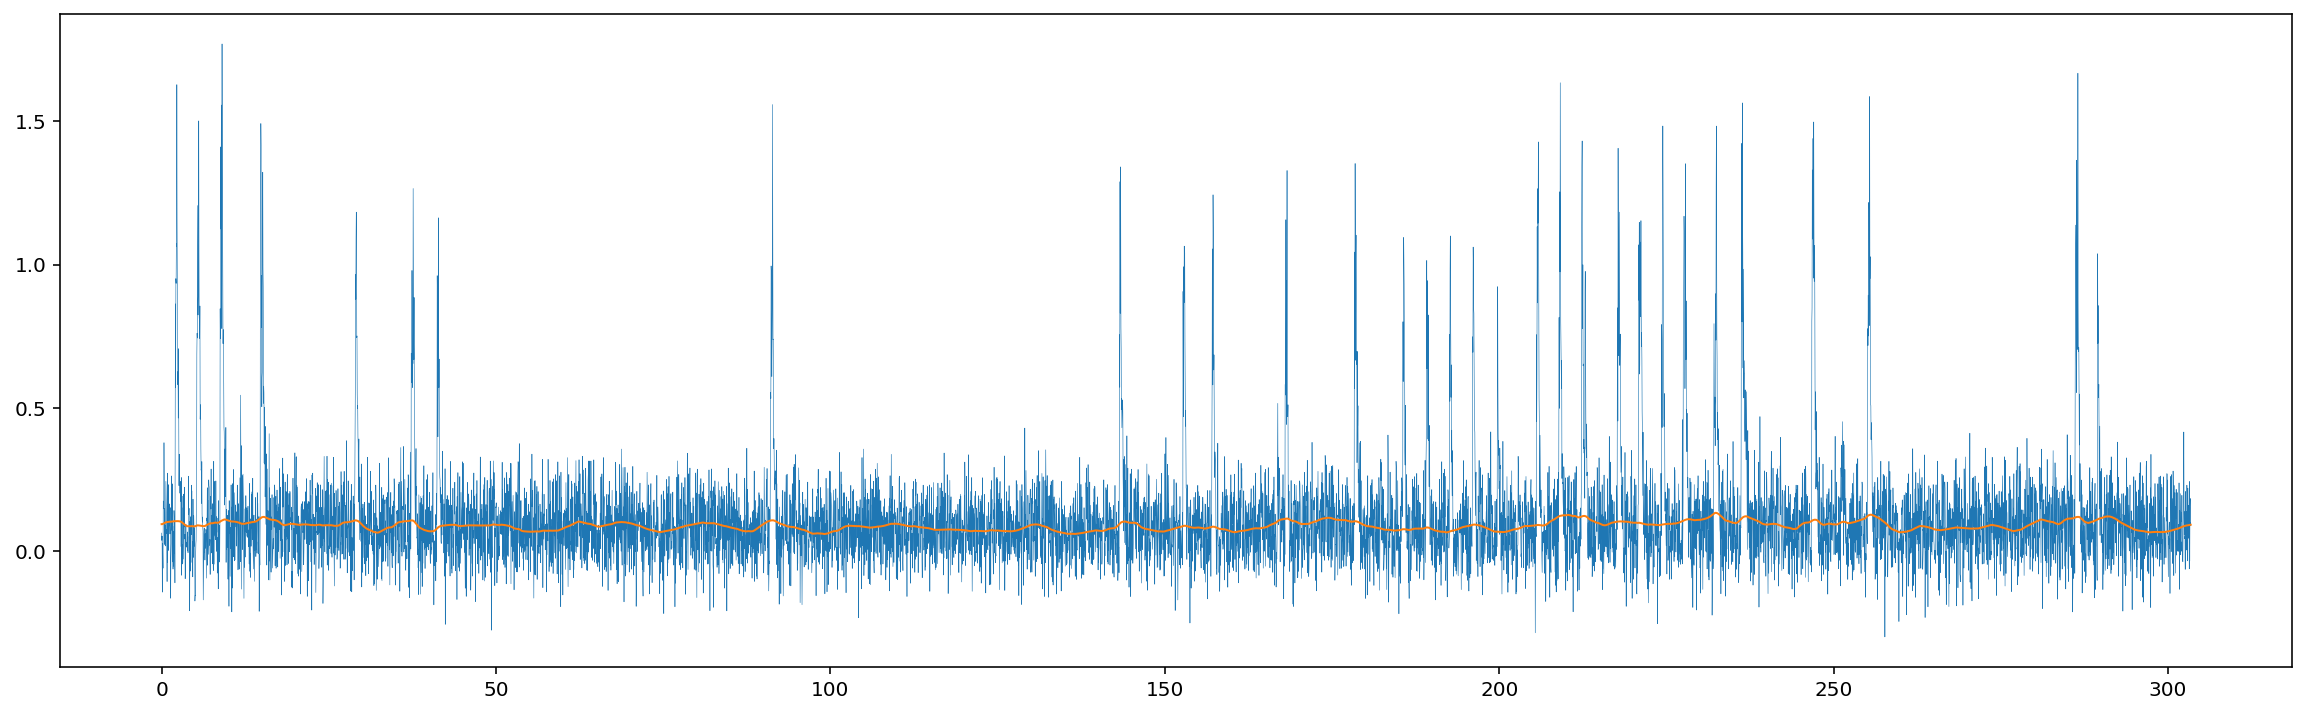

In [75]:
plt.figure(figsize=(20,6))

plt.plot(t,x,lw=.3)
wIronMode = wIron#*4+1
wIron1 = wIronMode*2+1
# xf = lowPass(runningMode(x,wIronMode,20),wIron1,wIron1,50)
xf = lowPass(x,wIron1,wIron1,50)
plt.plot(t,xf+ia*n,lw=1)

# x1 = x-xf

# plt.plot(t,x1,lw=.3)

# for f in [
#     lambda xi: ,
# #     lambda xi: lowPass(xi,wIron,wIron,10),
# #     lambda xi: lowPass(xi,wIron*2+1,wIron*2+1,10),
#     lambda xi: lowPass(runningMode(xi,wIron*2+1,20),wIron*2+1,wIron*2+1,50)
# ]:
#     xf = f(x)
#     plt.plot(t,xf+ia*n,lw=1)
#     x -= xf
#     ia -= 1
#     plt.plot(t,x+ia*n,lw=.3)
# # plt.xlim(2000,3000)

In [123]:
# lowPass(x,wIron,wIron,90,npass=2)-lowPass(x,wIron,wIron,[90])

In [124]:
# # f = plotTraces(regions,indices=[0,1], showCol=["faster_71"], offset=10)
# ix = np.arange(1,2)
# # f = plotTraces(regions,indices=ix, showCol=["trace","slower_2.5"][:], offset=0)
# f = plotTraces(regions,indices=ix, showCol=["faster_2.5"], offset=2)
# f.update_layout({"width":800,"height":200+50*np.log(len(ix))})
# f.show()

In [125]:
# # f = plotTraces(regions,indices=[0,1], showCol=["faster_71"], offset=10)
# ix = np.arange(4)
# f = plotTraces(regions,indices=ix, showCol=["trace"][:], offset=0)
# f.update_layout({"width":800,"height":200+50*np.log(len(ix))})
# f.show()

In [2]:
# def extractSubset(regions, indices):
#     from copy import deepcopy
#     saving = ['statImages', 'mode', 'image', 'filterSize', 'df', 'time']
#     allAttrs = list(regions.__dict__.keys())
#     subRegions = deepcopy(regions)
#     for k in allAttrs:
#         if k not in saving:
#             del subRegions.__dict__[k]
#     subRegions.df = subRegions.df.loc[indices]
#     return subRegions

In [38]:
img = np.load("local_data/Sandra/2019_10_15/Experiment38a/Experiment38a_5_Image014.npz")["data"][0]

In [39]:
img

array([[18, 23, 26, ..., 66, 59, 79],
       [14, 26, 33, ..., 70, 78, 78],
       [13, 25, 25, ..., 61, 66, 79],
       ...,
       [ 8, 16, 15, ..., 13, 11, 10],
       [11, 11, 10, ...,  8,  8, 11],
       [ 8, 11, 10, ...,  9,  8, 13]], dtype=uint8)

In [201]:
# plt.figure(figsize=(10,10))
# plt.imshow(np.log(1+img.astype(float)),origin="bottom")